## 1.Exploring Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Quick check of GPU type
!nvidia-smi
import os

Fri May 13 01:06:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Let's assign the training and testing directories
train_dir="../input/100-bird-species/train/"
test_dir="../input/100-bird-species/test/"

In [4]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'ALBATROSS' 'ALBERTS TOWHEE'
 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH' 'ALTAMIRA YELLOWTHROAT'
 'AMERICAN AVOCET' 'AMERICAN BITTERN' 'AMERICAN COOT' 'AMERICAN GOLDFINCH'
 'AMERICAN KESTREL' 'AMERICAN PIPIT' 'AMERICAN REDSTART'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY THRUSHBIRD'
 'ASIAN CRESTED IBIS' 'AVADAVAT' 'AZURE JAY' 'AZURE TANAGER' 'AZURE TIT'
 'BAIKAL TEAL' 'BALD EAGLE' 'BALD IBIS' 'BALI STARLING' 'BALTIMORE ORIOLE'
 'BANANAQUIT' 'BAND TAILED GUAN' 'BANDED BROADBILL' 'BANDED PITA'
 'BANDED STILT' 'BAR-TAILED GODWIT' 'BARN OWL' 'BARN SWALLOW'
 'BARRED PUFFBIRD' 'BARROWS GOLDENEYE' 'BAY-BREASTED WARBLER'
 'BEARDED BARBET' 'BEARDED BELLBIRD' 'BEARDED REEDLING'
 'BELTED KINGFISHE

## 2.Viewing Random Images

In [5]:
#Let's make a function to view a random image from a particular class
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [6]:
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras import layers,mixed_precision
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

['026.jpg']
Image shape: (224, 224, 3)


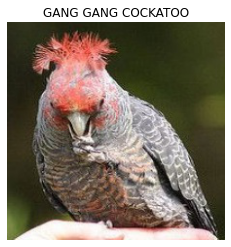

In [7]:
#Let's visualize some images
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## 3.Dividing into batches

In [8]:
#Let's divide the data into batches
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


## 4.Training data with TRANSFER LEARNING

In [11]:
eff_url="https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [12]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=400):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

In [13]:
# Create EfficientNet model 
effb7_model = create_model(eff_url,
                            num_classes=400)

2022-05-13 01:06:52.942856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 01:06:53.051121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 01:06:53.051918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-13 01:06:53.053100: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [14]:
# Compile our EfficientNet model
effb7_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [15]:
# Let's fit our EfficientNet model to the data 
history1 = effb7_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  )

2022-05-13 01:07:26.621617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-05-13 01:07:53.594587: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1825/1825 [==============================] - 506s 260ms/step - loss: 0.9597 - accuracy: 0.8120 - val_loss: 0.1931 - val_accuracy: 0.9615
Epoch 2/5
1825/1825 [==============================] - 411s 225ms/step - loss: 0.2526 - accuracy: 0.9421 - val_loss: 0.1124 - val_accuracy: 0.9720
Epoch 3/5
1825/1825 [==============================] - 410s 225ms/step - loss: 0.1513 - accuracy: 0.9661 - val_loss: 0.1030 - val_accuracy: 0.9735
Epoch 4/5
1825/1825 [==============================] - 410s 225ms/step - loss: 0.1003 - accuracy: 0.9777 - val_loss: 0.0892 - val_accuracy: 0.9750
Epoch 5/5
1825/1825 [==============================] - 410s 225ms/step - loss: 0.0688 - accuracy: 0.9845 - val_loss: 0.0722 - val_accuracy: 0.9800


## 5.Evaluating with loss curves

In [16]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

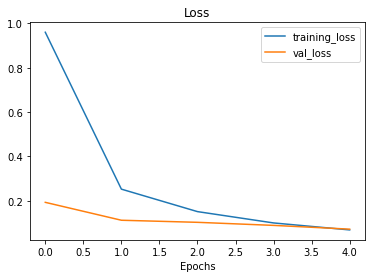

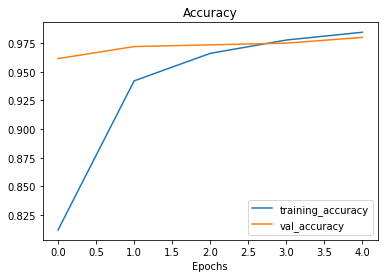

In [17]:
plot_loss_curves(history1)

In [18]:
effb7_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_lyaer (Ke (None, 2560)              64097680  
_________________________________________________________________
output_layer (Dense)         (None, 400)               1024400   
Total params: 65,122,080
Trainable params: 1,024,400
Non-trainable params: 64,097,680
_________________________________________________________________


## 6.Predicting custom images

In [19]:
#predicting custom image
# Create a function to import and image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it 
  to (img_shape, img_shape, colour_channels).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img
# Reconfig pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

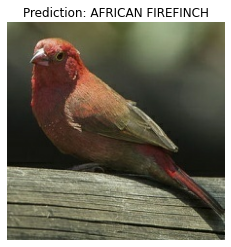

In [20]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/1.jpg",
              class_names=class_names)

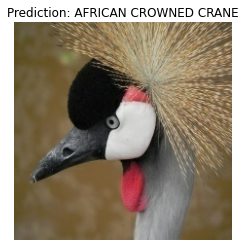

In [21]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/14.jpg",
              class_names=class_names)

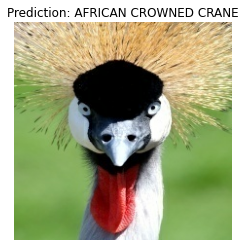

In [22]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/2.jpg",
              class_names=class_names)

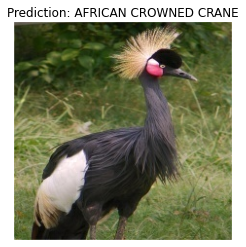

In [23]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/3.jpg",
              class_names=class_names)

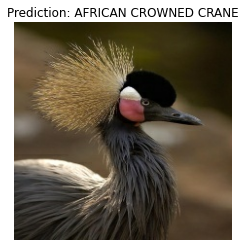

In [24]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/5.jpg",
              class_names=class_names)

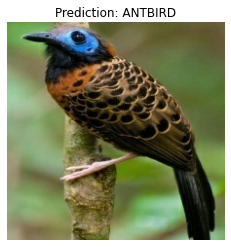

In [25]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/7.jpg",
              class_names=class_names)

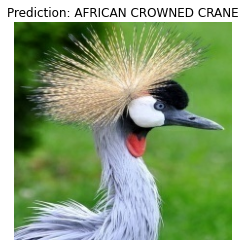

In [26]:
pred_and_plot(model=effb7_model,
              filename="../input/100-bird-species/images to test/4.jpg",
              class_names=class_names)

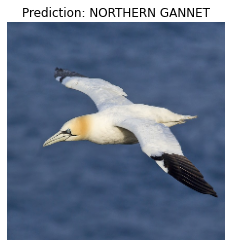

In [27]:
pred_and_plot(model=effb7_model,
              filename="../input/custom-birds/ng.jpg",
              class_names=class_names)

In [28]:
effb7_model.evaluate(test_data)

63/63 [==============================] - 14s 215ms/step - loss: 0.0722 - accuracy: 0.9800


[0.07224398106336594, 0.9800000190734863]